# Pre process 

In [1]:
import numpy as np
def check_df(df):
    print("=== Checking DataFrame ===")
    
    # Check for nulls
    nulls = df.isnull().sum()
    print("\nNull values per column:")
    print(nulls[nulls > 0] if nulls.sum() > 0 else "No nulls found")
    
    # Check for sparse data (defined here as >90% same value)
    print("\nChecking for sparse columns (>=90% same value):")
    for col in df.columns:
        top_freq = df[col].value_counts(normalize=True).max()
        if top_freq >= 0.9:
            print(f"Column '{col}' is sparse (top value frequency: {top_freq:.2f})")
    
    # Check if all columns are numeric
    non_numeric = df.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric) > 0:
        print("\nNon-numeric columns detected:")
        print(non_numeric)
    else:
        print("\nAll columns are numeric")


In [2]:
import pandas as pd

# Define the column names based on the structure you just showed
columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']

# Read the .data file
D2 = pd.read_csv("iris.data", names=columns)

# Show the first few rows
print(D2.head())
print(D2['class'].unique())


   sepal_length  sepal_width  petal_length  petal_width        class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [3]:
D2['class'] = D2['class'].map({
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
})
print(D2['class'])


0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: class, Length: 150, dtype: int64


In [4]:
check_df(D2)

=== Checking DataFrame ===

Null values per column:
No nulls found

Checking for sparse columns (>=90% same value):

All columns are numeric


In [5]:
### The Data is ready

# Exercise 1: Implement Decision Tree

### Part A: Basic Working and Cross Entropy

In [6]:
def train_test_split_manual(df, target_col, test_size=0.3, seed=42):
    # Shuffle the DataFrame
    df_shuffled = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    # Calculate the split index
    split_idx = int(len(df) * (1 - test_size))
    
    # Split into train and test
    train_df = df_shuffled.iloc[:split_idx]
    test_df = df_shuffled.iloc[split_idx:]
    
    # Separate features and target
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]
    X_test = test_df.drop(columns=[target_col])
    y_test = test_df[target_col]
    
    return X_train, X_test, y_train, y_test


In [7]:
# 1
X_train, X_test, y_train, y_test = train_test_split_manual(D2, target_col='class', test_size=0.3)

In [8]:
def entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities))


In [9]:
def info_gain(y, y_left, y_right):
    H_total = entropy(y)
    H_left = entropy(y_left)
    H_right = entropy(y_right)

    weight_left = len(y_left) / len(y)
    weight_right = len(y_right) / len(y)

    return H_total - (weight_left * H_left + weight_right * H_right)


In [10]:
def find_best_split(X_col, y):
    # Sort the data by the feature
    sorted_idx = np.argsort(X_col)
    X_col_sorted = X_col[sorted_idx]
    y_sorted = y[sorted_idx]
    
    best_gain = -1
    best_thresh = None

    # Try midpoints between unique values
    for i in range(1, len(X_col_sorted)):
        if X_col_sorted[i] == X_col_sorted[i - 1]:
            continue  # Skip duplicates

        threshold = (X_col_sorted[i] + X_col_sorted[i - 1]) / 2

        # Split y based on threshold
        y_left = y_sorted[X_col_sorted <= threshold]
        y_right = y_sorted[X_col_sorted > threshold]

        # Calculate info gain
        gain = info_gain(y_sorted, y_left, y_right)

        if gain > best_gain:
            best_gain = gain
            best_thresh = threshold

    return best_thresh, best_gain


In [11]:
def find_best_split_all_features(X, y):
    best_feature = None
    best_threshold = None
    best_gain = -1

    for feature in X.columns:
        X_col = X[feature].values
        threshold, gain = find_best_split(X_col, y)

        if gain > best_gain:
            best_gain = gain
            best_feature = feature
            best_threshold = threshold

    return best_feature, best_threshold, best_gain


In [12]:
import matplotlib.pyplot as plt

def plot_node_visuals(X, y, depth):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()

    # Prepare feature entropies
    feature_entropies = {}
    for feature in X.columns:
        X_col = X[feature].values
        sorted_idx = np.argsort(X_col)
        X_sorted = X_col[sorted_idx]
        y_sorted = y[sorted_idx]

        best_entropy = float('inf')

        for i in range(1, len(X_sorted)):
            if X_sorted[i] == X_sorted[i - 1]:
                continue
            threshold = (X_sorted[i] + X_sorted[i - 1]) / 2
            y_left = y_sorted[X_sorted <= threshold]
            y_right = y_sorted[X_sorted > threshold]

            w_left = len(y_left) / len(y_sorted)
            w_right = len(y_right) / len(y_sorted)

            entropy_split = w_left * entropy(y_left) + w_right * entropy(y_right)

            if entropy_split < best_entropy:
                best_entropy = entropy_split

        feature_entropies[feature] = best_entropy

    # Plot both charts side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Left: Class probabilities
    axs[0].bar(values, probs, tick_label=[f"Class {int(v)}" for v in values])
    axs[0].set_title(f"Depth {depth} - Class Probabilities")
    axs[0].set_xlabel("Class")
    axs[0].set_ylabel("Probability")
    axs[0].set_ylim(0, 1)

    # Right: Entropy of features
    axs[1].bar(feature_entropies.keys(), feature_entropies.values())
    axs[1].set_title(f"Depth {depth} - Entropy per Feature")
    axs[1].set_ylabel("Entropy")
    axs[1].set_ylim(0, 1.1)
    axs[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


In [15]:
def build_tree_entropy(X, y, depth=0, max_depth=3, min_gain=0.01):
    # Stop if node is pure (all y are the same)
    if len(np.unique(y)) == 1:
        return {'leaf': True, 'class_probs': class_probabilities(y)}

    # Stop if max depth is reached
    if depth >= max_depth:
        return {'leaf': True, 'class_probs': class_probabilities(y)}

    plot_node_visuals(X, y, depth)

    # Find best split
    feature, threshold, gain = find_best_split_all_features(X, y)

    # Stop if gain is too small
    if gain < min_gain:
        return {'leaf': True, 'class_probs': class_probabilities(y)}

    # Split data
    left_idx = X[feature] <= threshold
    right_idx = X[feature] > threshold

    X_left = X[left_idx].reset_index(drop=True)
    y_left = y[left_idx].reset_index(drop=True)
    X_right = X[right_idx].reset_index(drop=True)
    y_right = y[right_idx].reset_index(drop=True)

    # Recursively build subtrees
    left_subtree = build_tree_entropy(X_left, y_left, depth + 1, max_depth, min_gain)
    right_subtree = build_tree_entropy(X_right, y_right, depth + 1, max_depth, min_gain)

    return {
        'leaf': False,
        'feature': feature,
        'threshold': threshold,
        'gain': gain,
        'left': left_subtree,
        'right': right_subtree
    }


def class_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return dict(zip(values, probs))



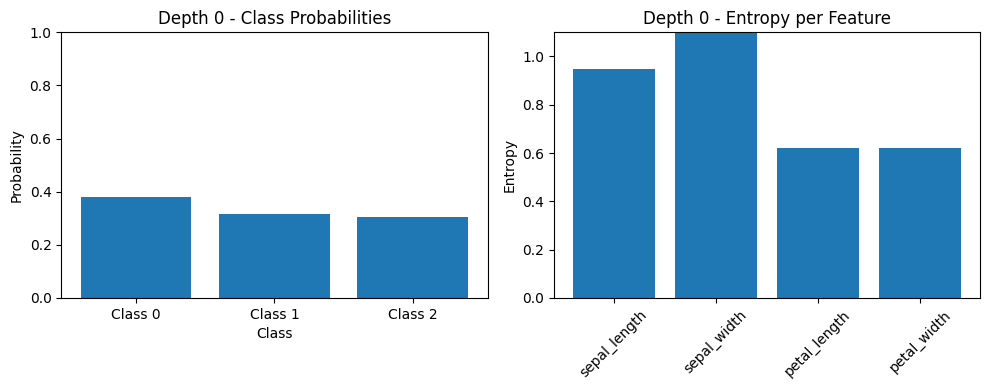

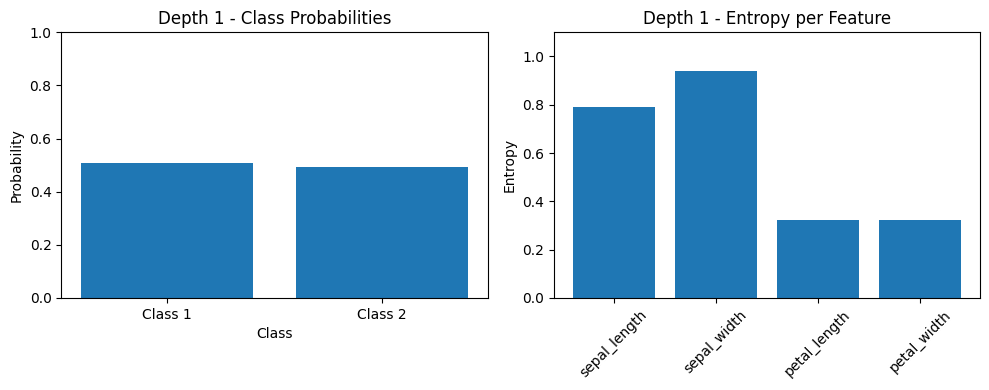

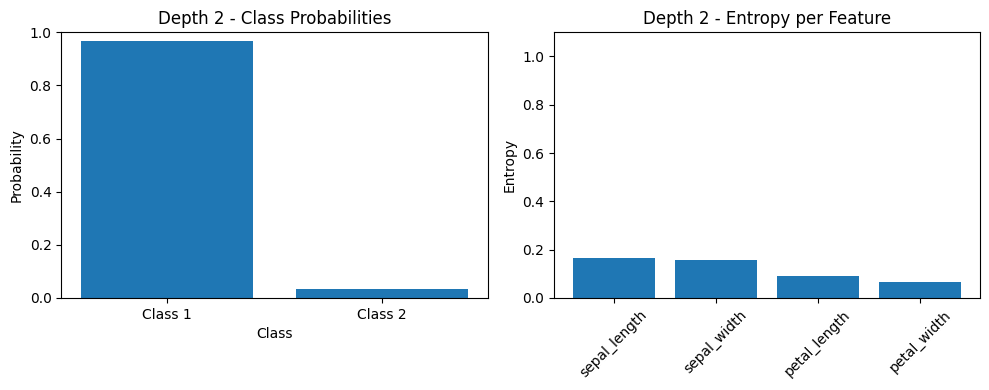

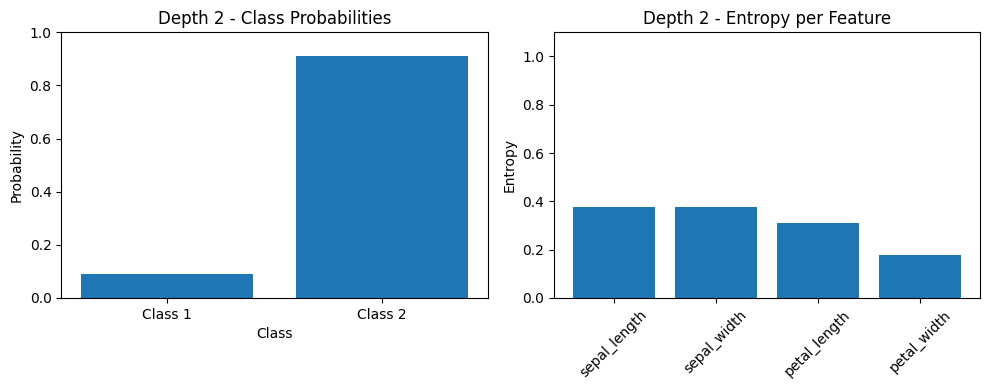

In [16]:
tree = build_tree_entropy(X_train, y_train, max_depth=3, min_gain=0.01)


In [17]:
from collections import deque

def print_tree(tree):
    queue = deque()
    queue.append((tree, 0))  # (node, depth)

    while queue:
        node, depth = queue.popleft()
        indent = "  " * depth  # for visual structure

        if node['leaf']:
            print(f"{indent}Leaf | depth={depth} | class_probs={node['class_probs']}")
        else:
            print(f"{indent}Node | depth={depth} | feature='{node['feature']}' "
                  f"| threshold={node['threshold']:.3f} | info_gain={node['gain']:.4f}")

            queue.append((node['left'], depth + 1))
            queue.append((node['right'], depth + 1))


In [18]:
print_tree(tree)


Node | depth=0 | feature='petal_length' | threshold=2.450 | info_gain=0.9587
  Leaf | depth=1 | class_probs={0: 1.0}
  Node | depth=1 | feature='petal_length' | threshold=4.850 | info_gain=0.6766
    Node | depth=2 | feature='petal_width' | threshold=1.700 | info_gain=0.1411
    Node | depth=2 | feature='petal_width' | threshold=1.750 | info_gain=0.2541
      Leaf | depth=3 | class_probs={1: 1.0}
      Leaf | depth=3 | class_probs={1: 0.5, 2: 0.5}
      Leaf | depth=3 | class_probs={1: 0.5, 2: 0.5}
      Leaf | depth=3 | class_probs={2: 1.0}


In [19]:
#Calcuating the Accuricy just for myslef in order to understand to model better

def predict_one(tree, x):
    if tree['leaf']:
        # Choose the class with highest probability
        return max(tree['class_probs'], key=tree['class_probs'].get)
    else:
        if x[tree['feature']] <= tree['threshold']:
            return predict_one(tree['left'], x)
        else:
            return predict_one(tree['right'], x)

def predict(tree, X):
    return [predict_one(tree, x) for _, x in X.iterrows()]


In [20]:
y_pred = predict(tree, X_test)
accuracy = np.mean(np.array(y_pred) == np.array(y_test))
print("Accuracy:", accuracy)


Accuracy: 0.9333333333333333


In [21]:
def cross_entropy_loss(tree, X, y_true):
    total_loss = 0

    for i in range(len(X)):
        x = X.iloc[i]
        true_label = y_true.iloc[i]

        # Navigate to the leaf
        node = tree
        while not node['leaf']:
            if x[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']

        # Get the predicted probability for the true class
        probs = node['class_probs']
        p = probs.get(true_label, 1e-10)  # fallback for missing class
        total_loss += -np.log2(p)

    return total_loss / len(X)


In [22]:
loss = cross_entropy_loss(tree, X_test, y_test)
print("Cross Entropy Loss:", loss)


Cross Entropy Loss: 0.8048729099749694


# to conclude this part
The tree shows strong splits using petal_length and petal_width, with high info gain at the root.
Most leaf nodes are pure, but some mixed ones reflect limited depth and class overlap.
A cross-entropy loss of 0.80 suggests decent but not perfect confidence in predictions.

# Part B: Experiment with Other Quality-Criteria

In [23]:
#Implementioan of GINI

def gini(y):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return 1 - np.sum(probs ** 2)


In [24]:
def gini_gain(y, y_left, y_right):
    g_total = gini(y)
    w_left = len(y_left) / len(y)
    w_right = len(y_right) / len(y)
    return g_total - (w_left * gini(y_left) + w_right * gini(y_right))


In [25]:
def find_best_split_all_features(X, y, criterion="entropy"):
    best_feature = None
    best_threshold = None
    best_gain = -1

    for feature in X.columns:
        X_col = X[feature].values
        threshold, gain = find_best_split(X_col, y, criterion)
        if gain > best_gain:
            best_gain = gain
            best_feature = feature
            best_threshold = threshold

    return best_feature, best_threshold, best_gain


In [26]:
def build_tree_gini(X, y, depth=0, max_depth=3, min_gain=0.01, criterion="entropy"):
    # Stop if node is pure (all y are the same)
    if len(np.unique(y)) == 1:
        return {'leaf': True, 'class_probs': class_probabilities(y)}

    # Stop if max depth is reached
    if depth >= max_depth:
        return {'leaf': True, 'class_probs': class_probabilities(y)}

    plot_node_visuals(X, y, depth)

    # Find best split
    feature, threshold, gain = find_best_split_all_features(X, y, criterion)

    # Stop if gain is too small
    if gain < min_gain:
        return {'leaf': True, 'class_probs': class_probabilities(y)}

    # Split data
    left_idx = X[feature] <= threshold
    right_idx = X[feature] > threshold

    X_left = X[left_idx].reset_index(drop=True)
    y_left = y[left_idx].reset_index(drop=True)
    X_right = X[right_idx].reset_index(drop=True)
    y_right = y[right_idx].reset_index(drop=True)

    # Recursively build subtrees
    left_subtree = build_tree_gini(X_left, y_left, depth + 1, max_depth, min_gain)
    right_subtree = build_tree_gini(X_right, y_right, depth + 1, max_depth, min_gain)

    return {
        'leaf': False,
        'feature': feature,
        'threshold': threshold,
        'gain': gain,
        'left': left_subtree,
        'right': right_subtree
    }


def class_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return dict(zip(values, probs))



In [27]:
def find_best_split(X_col, y, criterion="entropy"):
    sorted_idx = np.argsort(X_col)
    X_sorted = X_col[sorted_idx]
    y_sorted = y[sorted_idx]

    best_gain = -1
    best_thresh = None

    for i in range(1, len(X_sorted)):
        if X_sorted[i] == X_sorted[i - 1]:
            continue

        threshold = (X_sorted[i] + X_sorted[i - 1]) / 2
        y_left = y_sorted[X_sorted <= threshold]
        y_right = y_sorted[X_sorted > threshold]

        if criterion == "entropy":
            gain = info_gain(y_sorted, y_left, y_right)
        elif criterion == "gini":
            gain = gini_gain(y_sorted, y_left, y_right)
        else:
            raise ValueError("Unknown criterion")

        if gain > best_gain:
            best_gain = gain
            best_thresh = threshold

    return best_thresh, best_gain


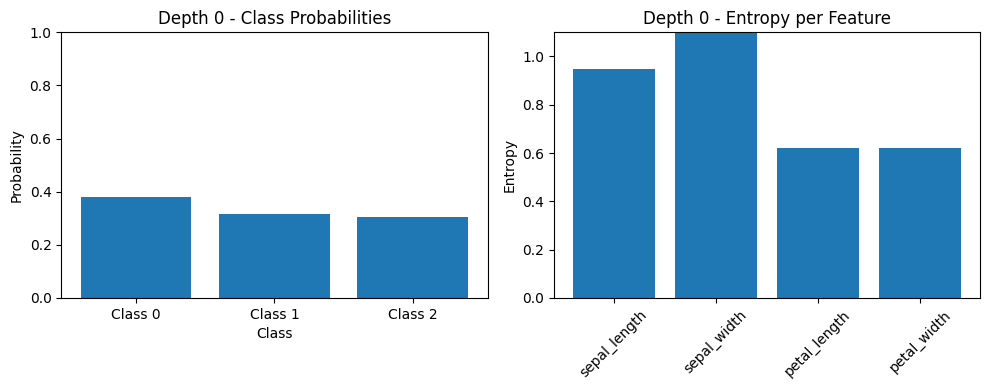

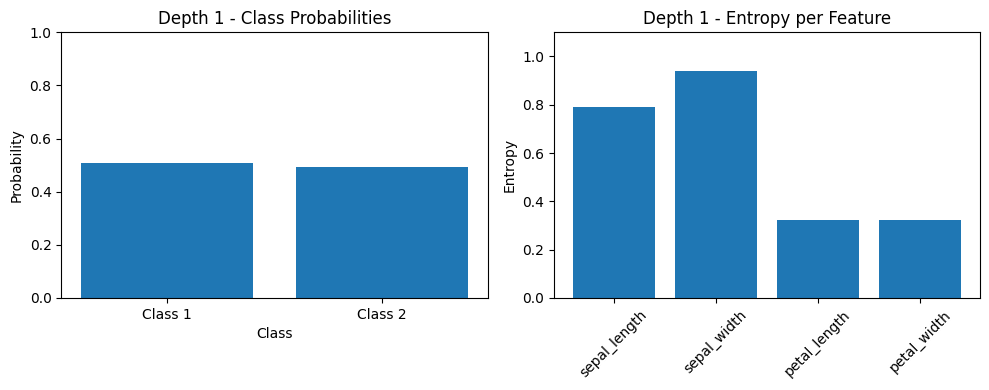

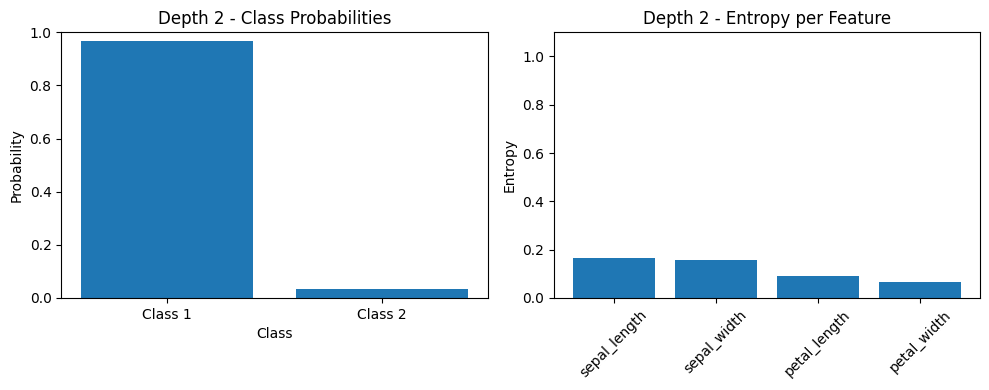

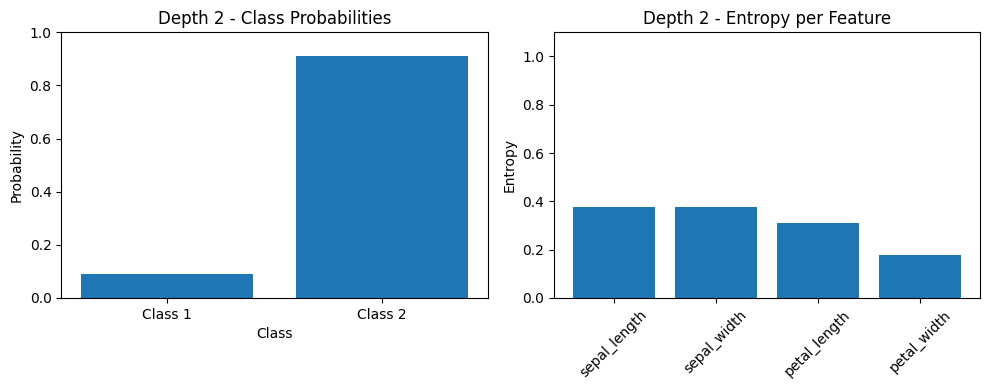

In [28]:
tree_gini = build_tree_gini(X_train, y_train, criterion="gini")


In [29]:
print ("----------Comparision between GINI tree and Cross Entropy ----------")
print ("---------Cross Entropy ----------")

print_tree(tree)
print ("---------GINI ----------")

print_tree(tree_gini)


----------Comparision between GINI tree and Cross Entropy ----------
---------Cross Entropy ----------
Node | depth=0 | feature='petal_length' | threshold=2.450 | info_gain=0.9587
  Leaf | depth=1 | class_probs={0: 1.0}
  Node | depth=1 | feature='petal_length' | threshold=4.850 | info_gain=0.6766
    Node | depth=2 | feature='petal_width' | threshold=1.700 | info_gain=0.1411
    Node | depth=2 | feature='petal_width' | threshold=1.750 | info_gain=0.2541
      Leaf | depth=3 | class_probs={1: 1.0}
      Leaf | depth=3 | class_probs={1: 0.5, 2: 0.5}
      Leaf | depth=3 | class_probs={1: 0.5, 2: 0.5}
      Leaf | depth=3 | class_probs={2: 1.0}
---------GINI ----------
Node | depth=0 | feature='petal_length' | threshold=2.450 | info_gain=0.3538
  Leaf | depth=1 | class_probs={0: 1.0}
  Node | depth=1 | feature='petal_length' | threshold=4.850 | info_gain=0.6766
    Node | depth=2 | feature='petal_width' | threshold=1.700 | info_gain=0.1411
    Node | depth=2 | feature='petal_width' | thr

In [30]:
def plot_gini_vs_entropy(X, y, depth):
    features = X.columns
    entropy_scores = []
    gini_scores = []
    info_gains = []
    gini_gains = []

    for feature in features:
        X_col = X[feature].values
        sorted_idx = np.argsort(X_col)
        X_sorted = X_col[sorted_idx]
        y_sorted = y[sorted_idx]

        best_entropy = float('inf')
        best_info_gain = -1
        best_gini = float('inf')
        best_gini_gain = -1

        for i in range(1, len(X_sorted)):
            if X_sorted[i] == X_sorted[i - 1]:
                continue
            threshold = (X_sorted[i] + X_sorted[i - 1]) / 2

            y_left = y_sorted[X_sorted <= threshold]
            y_right = y_sorted[X_sorted > threshold]

            # Info gain
            ig = info_gain(y_sorted, y_left, y_right)
            eg = gini_gain(y_sorted, y_left, y_right)

            ent = (len(y_left) / len(y)) * entropy(y_left) + (len(y_right) / len(y)) * entropy(y_right)
            gin = (len(y_left) / len(y)) * gini(y_left) + (len(y_right) / len(y)) * gini(y_right)

            if ent < best_entropy:
                best_entropy = ent
            if ig > best_info_gain:
                best_info_gain = ig
            if gin < best_gini:
                best_gini = gin
            if eg > best_gini_gain:
                best_gini_gain = eg

        entropy_scores.append(best_entropy)
        gini_scores.append(best_gini)
        info_gains.append(best_info_gain)
        gini_gains.append(best_gini_gain)

    # Plot
    x = np.arange(len(features))
    width = 0.2

    plt.figure(figsize=(10, 5))
    plt.bar(x - 1.5*width, entropy_scores, width, label='Entropy')
    plt.bar(x - 0.5*width, gini_scores, width, label='Gini')
    plt.bar(x + 0.5*width, info_gains, width, label='Info Gain')
    plt.bar(x + 1.5*width, gini_gains, width, label='Gini Gain')

    plt.xticks(x, features, rotation=45)
    plt.title(f"Depth {depth} - Quality Criteria Comparison")
    plt.ylabel("Score")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [31]:
def build_tree_for_plot(X, y, depth=0, max_depth=3, min_gain=0.01, criterion="entropy"):
    # Stop if node is pure (all y are the same)
    if len(np.unique(y)) == 1:
        return {'leaf': True, 'class_probs': class_probabilities(y)}

    # Stop if max depth is reached
    if depth >= max_depth:
        return {'leaf': True, 'class_probs': class_probabilities(y)}

    plot_gini_vs_entropy(X, y, depth)
    # Find best split
    feature, threshold, gain = find_best_split_all_features(X, y, criterion)

    # Stop if gain is too small
    if gain < min_gain:
        return {'leaf': True, 'class_probs': class_probabilities(y)}

    # Split data
    left_idx = X[feature] <= threshold
    right_idx = X[feature] > threshold

    X_left = X[left_idx].reset_index(drop=True)
    y_left = y[left_idx].reset_index(drop=True)
    X_right = X[right_idx].reset_index(drop=True)
    y_right = y[right_idx].reset_index(drop=True)

    # Recursively build subtrees
    left_subtree = build_tree_for_plot(X_left, y_left, depth + 1, max_depth, min_gain)
    right_subtree = build_tree_for_plot(X_right, y_right, depth + 1, max_depth, min_gain)

    return {
        'leaf': False,
        'feature': feature,
        'threshold': threshold,
        'gain': gain,
        'left': left_subtree,
        'right': right_subtree
    }


def class_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return dict(zip(values, probs))



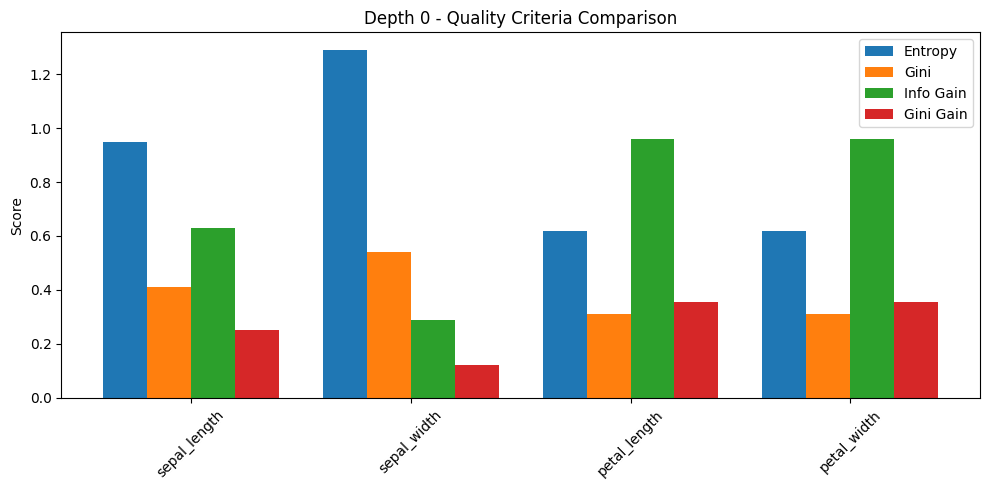

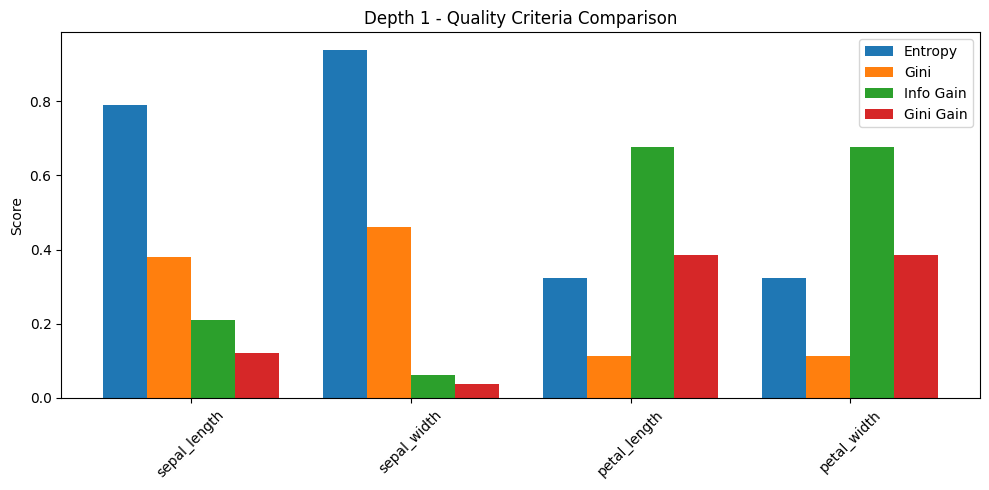

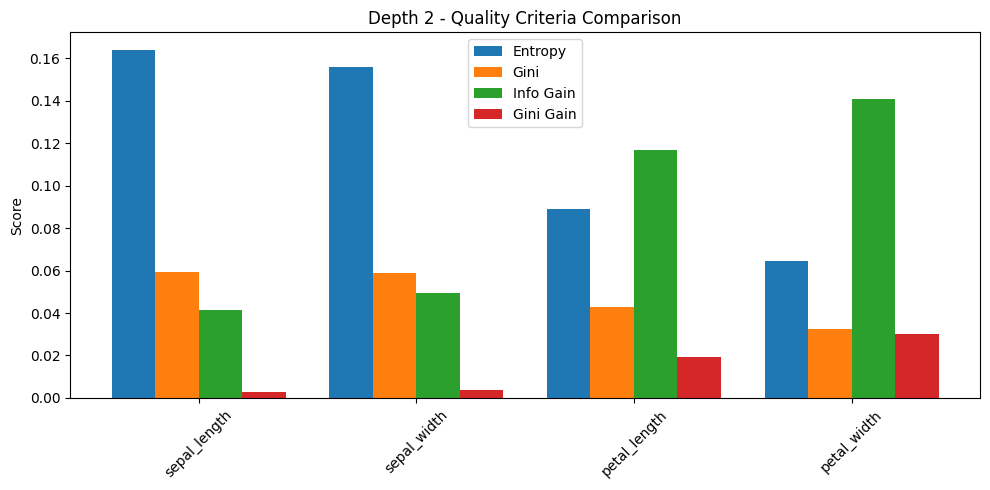

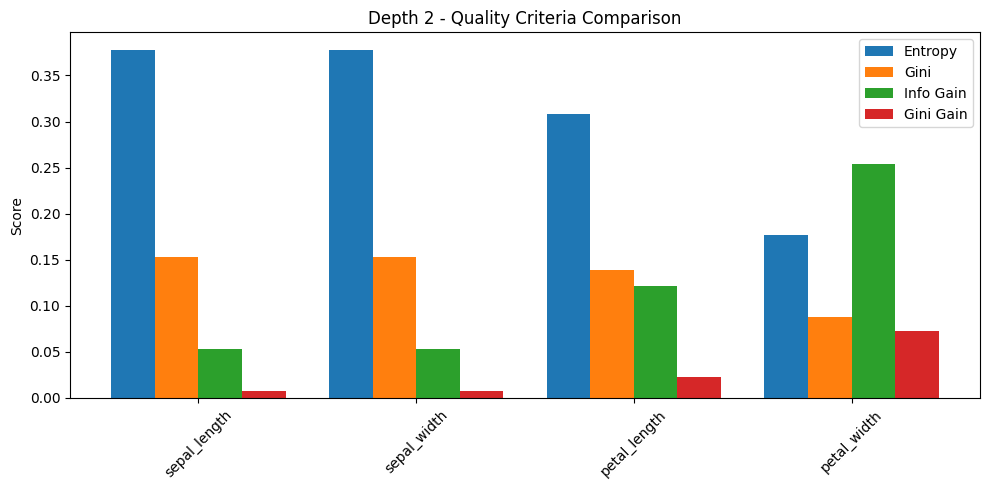

In [33]:
tree_for_compare = build_tree_for_plot(X_train, y_train, max_depth=3, min_gain=0.01)


In [34]:
# 4. Evaluate the test set performance and compare both criteria.
# loss on the Tree from Part A (entropy-based)

loss_entropy = cross_entropy_loss(tree, X_test, y_test)

# Loss on The gini tree from  Part B (gini-based)
loss_gini = cross_entropy_loss(tree_gini, X_test, y_test)

pred_entropy = predict(tree, X_test)
pred_gini = predict(tree_gini, X_test)

acc_entropy = np.mean(np.array(pred_entropy) == np.array(y_test))
acc_gini = np.mean(np.array(pred_gini) == np.array(y_test))

# Final comparison print
print("-------- Final Performance Comparison --------")
print(f"Cross Entropy Loss (Entropy tree): {loss_entropy:.4f}")
print(f"Cross Entropy Loss (Gini tree):    {loss_gini:.4f}")
print(f"Accuracy (Entropy tree):           {acc_entropy:.4f}")
print(f"Accuracy (Gini tree):              {acc_gini:.4f}")


-------- Final Performance Comparison --------
Cross Entropy Loss (Entropy tree): 0.8049
Cross Entropy Loss (Gini tree):    0.8049
Accuracy (Entropy tree):           0.9333
Accuracy (Gini tree):              0.9333


# Exercise 2: Pruning the Decision Tree 


In [36]:
#Split The Data

import numpy as np
import pandas as pd

# Shuffle the dataset
D2_shuffled = D2.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate sizes
n_total = len(D2_shuffled)
n_train = int(0.34 * n_total)
n_val = int(0.33 * n_total)
n_test = n_total - n_train - n_val  # Remaining for test

# Split
train_set = D2_shuffled.iloc[:n_train]
val_set = D2_shuffled.iloc[n_train:n_train + n_val]
test_set = D2_shuffled.iloc[n_train + n_val:]

# Extract features and labels
X_train = train_set.drop(columns=["class"])
y_train = train_set["class"]

X_val = val_set.drop(columns=["class"])
y_val = val_set["class"]

X_test = test_set.drop(columns=["class"])
y_test = test_set["class"]


In [37]:
def prune_tree(node, X_val, y_val):
    if node['leaf']:
        return node

    # Recursively prune children first
    node['left'] = prune_tree(node['left'], X_val, y_val)
    node['right'] = prune_tree(node['right'], X_val, y_val)

    # Now test pruning this node
    original_node = node.copy()

    # Make a temporary leaf
    X_node = X_val[apply_tree_mask(node, X_val)]
    y_node = y_val.loc[X_node.index]

    if len(y_node) == 0:
        return node  # No data to evaluate pruning

    new_leaf = {
        'leaf': True,
        'class_probs': class_probabilities(y_node)
    }

    # Replace current node with leaf and check validation loss
    temp_node = new_leaf
    loss_pruned = cross_entropy_loss(temp_node, X_node, y_node)
    loss_full = cross_entropy_loss(original_node, X_node, y_node)

    print(f"Pruning decision at node with feature '{node['feature']}':")
    print(f"  → Parent info gain: {node['gain']:.4f}")
    print(f"  → Loss before pruning: {loss_full:.4f}, after: {loss_pruned:.4f}")

    if loss_pruned <= loss_full:
        return new_leaf  # Prune the node
    else:
        return node  # Keep full subtree


In [39]:
tree_gini


{'leaf': False,
 'feature': 'petal_length',
 'threshold': 2.45,
 'gain': 0.35376940519797667,
 'left': {'leaf': True, 'class_probs': {0: 1.0}},
 'right': {'leaf': False,
  'feature': 'petal_length',
  'threshold': 4.85,
  'gain': 0.6765657027065857,
  'left': {'leaf': False,
   'feature': 'petal_width',
   'threshold': 1.7000000000000002,
   'gain': 0.14107637915282495,
   'left': {'leaf': True, 'class_probs': {1: 1.0}},
   'right': {'leaf': True, 'class_probs': {1: 0.5, 2: 0.5}}},
  'right': {'leaf': False,
   'feature': 'petal_width',
   'threshold': 1.75,
   'gain': 0.2540812787751453,
   'left': {'leaf': True, 'class_probs': {1: 0.5, 2: 0.5}},
   'right': {'leaf': True, 'class_probs': {2: 1.0}}}}}

def display_pruning_gains(node, depth=0):
    if node['leaf']:
        return 0  # Leaf nodes don't have gain

    # Current node's gain
    parent_gain = node.get('gain', 0)

    # If children are leaf nodes, their gain is 0
    left_gain = node['left'].get('gain', 0) if not node['left']['leaf'] else 0
    right_gain = node['right'].get('gain', 0) if not node['right']['leaf'] else 0

    # Print info
    indent = "  " * depth
    print(f"{indent}Node (Feature: {node['feature']}, Threshold: {node['threshold']})")
    print(f"{indent}  Parent Gain: {parent_gain:.4f}")
    print(f"{indent}  Children Gain Sum: {left_gain + right_gain:.4f}\n")

    # Recurse
    display_pruning_gains(node['left'], depth + 1)
    display_pruning_gains(node['right'], depth + 1)


display_pruning_gains(tree_gini)


In [42]:
def predict_proba(tree, x):
    node = tree
    while not node['leaf']:
        feature = node['feature']
        threshold = node['threshold']
        if x[feature] <= threshold:
            node = node['left']
        else:
            node = node['right']
    return node['class_probs']


In [49]:
import numpy as np

def cross_entropy_loss(tree, X, y, num_classes=3):
    loss = 0
    for i in range(len(X)):
        x_i = X.iloc[i]
        true_label = y.iloc[i]
        probs_dict = predict_proba(tree, x_i)
        
        # Convert to a probability vector for all classes
        probs = np.array([probs_dict.get(c, 0) for c in range(num_classes)])
        
        # Clip to avoid log(0)
        probs = np.clip(probs, 1e-15, 1)
        
        loss -= np.log(probs[true_label])
    
    return loss / len(X)


In [50]:
loss_before_pruning = cross_entropy_loss(tree_gini, X_test, y_test)
print(f"Cross Entropy Loss (Before Pruning): {loss_before_pruning:.4f}")


Cross Entropy Loss (Before Pruning): 0.8528


### Post-Pruning Using Reduced Error Pruning (REP)

In [51]:
def filter_samples_at_node(tree, X):
    """Return boolean mask for samples that reach this node."""
    node = tree
    mask = pd.Series([True] * len(X), index=X.index)
    
    while not node['leaf']:
        feature = node['feature']
        threshold = node['threshold']
        
        go_left = X[feature] <= threshold
        node = node['left'] if node['leaf'] is False and go_left.all() else node['right']
        
        mask &= go_left if node == node['left'] else ~go_left
    
    return mask


In [52]:
import copy

def get_majority_class(y):
    return y.value_counts(normalize=True).to_dict()

def prune_tree(node, X_val, y_val):
    if node['leaf']:
        return node  # Already a leaf, nothing to do

    # Recursively prune children
    node['left'] = prune_tree(node['left'], X_val, y_val)
    node['right'] = prune_tree(node['right'], X_val, y_val)

    # Make a deep copy of the original subtree
    original_subtree = copy.deepcopy(node)

    # Find samples that reach this node
    def samples_reaching_node(x_row, node):
        while not node['leaf']:
            feature = node['feature']
            threshold = node['threshold']
            if x_row[feature] <= threshold:
                node = node['left']
            else:
                node = node['right']
        return True  # If it reaches, return True

    # Apply the check for all rows
    reaching_mask = X_val.apply(lambda row: samples_reaching_node(row, node), axis=1)
    X_reach = X_val[reaching_mask]
    y_reach = y_val[reaching_mask]

    # If no samples reach here, skip pruning
    if len(y_reach) == 0:
        return node

    # Temporarily prune: make this node a leaf
    pruned_node = {
        'leaf': True,
        'class_probs': get_majority_class(y_reach)
    }

    # Evaluate loss before and after pruning
    original_loss = cross_entropy_loss(tree_gini, X_val, y_val)
    temp_tree = copy.deepcopy(tree_gini)
    _replace_subtree(temp_tree, node, pruned_node)
    pruned_loss = cross_entropy_loss(temp_tree, X_val, y_val)

    # Keep pruning only if it improves or maintains performance
    if pruned_loss <= original_loss:
        return pruned_node
    else:
        return node

def _replace_subtree(tree, target_node, replacement_node):
    """Recursively replace target_node with replacement_node."""
    if tree is target_node:
        tree.clear()
        tree.update(replacement_node)
        return True
    if not tree['leaf']:
        if _replace_subtree(tree['left'], target_node, replacement_node):
            return True
        if _replace_subtree(tree['right'], target_node, replacement_node):
            return True
    return False


In [54]:
tree_pruned = prune_tree(tree_gini, X_val, y_val)
# Evaluate before pruning (already done earlier)
loss_before = cross_entropy_loss(tree_gini, X_test, y_test)

# Evaluate after pruning
loss_after = cross_entropy_loss(tree_pruned, X_test, y_test)

print(f"Cross Entropy Loss (Before Pruning): {loss_before:.4f}")
print(f"Cross Entropy Loss (After Pruning):  {loss_after:.4f}")



Cross Entropy Loss (Before Pruning): 0.8528
Cross Entropy Loss (After Pruning):  1.1131


In [57]:
# the cross entropy loss from ex1 0.8048729099749694

# Comparison and Conclusion
In Exercise 1, the decision tree was trained using 70% of the dataset and evaluated on the remaining 30%, with Cross Entropy as the splitting criterion. This model achieved a Cross Entropy Loss of 0.8049. In contrast, for the pruning task in Exercise 2, the tree was built using only 34% of the data and was based on the Gini index instead of Cross Entropy. Before pruning, the model achieved a loss of 0.8528, and after applying Reduced Error Pruning, the loss increased to 1.1131. This comparison shows that pruning the Gini-based tree harmed performance, likely due to the reduced training data and already minimal complexity. Conclusion: In this case, the tree should not be pruned, as pruning did not improve — and even worsened — its predictive confidence.